In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'/home/beans/bespoke')

from constants import *
from imports import *
from viz_utils import *
from train_utils import *
from traj_utils import *
from loaders import RunLoader
import threading

In [4]:
#run_id = "run_556a" # rr from hh to end pavement
#run_id = "run_556b" # po to end hh
#run_id = "run_555a" # rr out, sunny, glare
#run_id = "run_556c" # rr gravel
#556d, rr paved to gravel all the way home
#555b, rr sharp curve to PO

run_ids = ["run_555b", "run_556d"] + ["run_555a", "run_556a", "run_556b", "run_556c"]

In [3]:
# Temporary. Copying old rw into new format. Can delete when get new rw data.

for run_id in run_ids:
    run_path = f"/media/beans/ssd/bespoke_logging/{run_id}"

    for p in sorted(glob.glob(f"{run_path}/car_state/*")):
        cs = np.load(p)
        aux = get_aux_container(1,1)[0][0]
        aux["tire_angle"] = np.radians(cs[0]/STEER_RATIO)*-1
        aux["speed"] = cs[1]
        aux["pitch"] = 0
        aux["yaw"] = .5
        aux["pos_x"] = cs[13]
        aux["pos_y"] = cs[12]
        aux["has_map"] = 1
        aux["has_route"] = 1
        aux["tire_angle_lagged"] = aux["tire_angle"]
        aux["has_tire_angle"] = 0 #1
        np.save(f"{run_path}/aux/{p.split('/')[-1]}", aux)


In [ ]:
%%time
# Save rw data as Run object for faster loading. 
# Each time get a new rw run, or when update Run apparatus, rerun this

def do_run(run_id):
    run_path = f"{SSD_ROOT}/bespoke_logging/{run_id}"
    # NOTE you may have to redraw maps here
    run = RunLoader(run_path, is_rw=True, redraw_maps=False, _gamma_correct_auto=False)
    print(run.img_chunk.shape, run.aux_chunk.shape, run.targets_chunk.shape)
    save_object(run, f"{BESPOKE_ROOT}/tmp/runs/{run_id}.pkl")
    
threads = []
run_ids = ["run_583a", "run_584a"]
for run_id in run_ids:
    t = threading.Thread(target=do_run, args=(run_id,))
    t.start()
    threads.append(t)

for t in threads:
    t.join()

In [3]:
#run_id = "run_555" # Out to ned, correct sized map, sun glary?
#run_id = "run_556" # back from ned, correct sized map

#run_id = "run_556a" # rr from hh to end pavement
#run_id = "run_556b" # po to end hh
#run_id = "run_555a" # rr out, sunny, glare
#run_id = "run_556c" # rr gravel
run_id = "run_567" # back from PO all the way to home. Rds messy w half-snow
run_id = "run_566" # home to PO. Rds messy w half-snow
run_id = "run_555b"


In [2]:
sorted(glob.glob("/media/beans/ssd/bespoke_logging/*"))

['/media/beans/ssd/bespoke_logging/run_561',
 '/media/beans/ssd/bespoke_logging/run_562',
 '/media/beans/ssd/bespoke_logging/run_563',
 '/media/beans/ssd/bespoke_logging/run_564',
 '/media/beans/ssd/bespoke_logging/run_565',
 '/media/beans/ssd/bespoke_logging/run_566',
 '/media/beans/ssd/bespoke_logging/run_567',
 '/media/beans/ssd/bespoke_logging/run_568',
 '/media/beans/ssd/bespoke_logging/run_569',
 '/media/beans/ssd/bespoke_logging/run_570',
 '/media/beans/ssd/bespoke_logging/run_570a',
 '/media/beans/ssd/bespoke_logging/run_571',
 '/media/beans/ssd/bespoke_logging/run_571a',
 '/media/beans/ssd/bespoke_logging/run_572',
 '/media/beans/ssd/bespoke_logging/run_572a',
 '/media/beans/ssd/bespoke_logging/run_573',
 '/media/beans/ssd/bespoke_logging/run_573a',
 '/media/beans/ssd/bespoke_logging/run_574',
 '/media/beans/ssd/bespoke_logging/run_575',
 '/media/beans/ssd/bespoke_logging/run_576',
 '/media/beans/ssd/bespoke_logging/run_577',
 '/media/beans/ssd/bespoke_logging/run_578',
 '/med

### save individual run

In [3]:
%%time
# save new run 
run_id = "run_639"
run_path = f"{SSD_ROOT}/bespoke_logging/{run_id}"
run = RunLoader(run_path, is_rw=True, redraw_maps=False, _gamma_correct_auto=False)
save_object(run, f"{BESPOKE_ROOT}/tmp/runs/{run_id}.pkl")

loaded imgs and aux
CPU times: user 23.5 s, sys: 2min 16s, total: 2min 39s
Wall time: 3min 30s


In [4]:
# run_id = "run_621"
#run = load_object(f"{BESPOKE_ROOT}/tmp/runs/{run_id}.pkl")

In [5]:
run.aux_chunk.shape

(1, 23756, 40)

In [49]:
len(run.aux_chunk.names)

40

In [50]:
n = [nn for nn in run.aux_chunk.names if nn!="ego_in_intx"]

In [53]:
run.aux_chunk.names = n

In [54]:
# get new aux container after refreshing aux props

new_aux = get_aux_container(run.aux_chunk.shape[0], run.aux_chunk.shape[1])
for p in run.aux_chunk.names:
    new_aux[0, :, p] = run.aux_chunk[0,:,p]
run.aux_chunk = new_aux
save_object(run, f"{BESPOKE_ROOT}/tmp/runs/{run_id}.pkl")

### Post train, save rollouts and vids for all runs

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'/home/beans/bespoke')

from constants import *
from imports import *
from viz_utils import *
from train_utils import *
from traj_utils import *
from loaders import RunLoader
import threading
from rollout import *
import wandb

In [2]:
model_stem = "7.9_e81" #"5.25_e60" #"3.13_e150" #"3.10_e16" #"2.22_e79"

In [3]:
m = EffNet().to(device) 
m.model_stem = model_stem
m.use_rnn = False
m = try_load_state_dict(m, torch.load(f"{BESPOKE_ROOT}/models/m{model_stem}.torch"))

In [4]:
runs = ["run_636"] #["run_621", "run_622"] #["run_596"] #["run_570a", "run_571a"]
#runs = ["run_588a"] #["run_583a", "run_584a"]

0
resetting hidden carousel


/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


3200
6400
9600
12800
16000
19200
22400
25600
28800
32000
35200
loader is done
Stopsign approaching! 54.93
Stopsign approaching! 50.29
Stopsign approaching! 46.08
Stopsign approaching! 42.34
Stopsign approaching! 38.96
Stopsign approaching! 36.52
Stopsign approaching! 54.23
Stopsign approaching! 48.96
Stopsign approaching! 44.34
Stopsign approaching! 40.17
Stopsign approaching! 36.49
Stopsign approaching! 33.27
Stopsign approaching! 31.37
Stopsign approaching! 29.28
Stopsign approaching! 26.69
Stopsign approaching! 24.88
Stopsign approaching! 22.94
Stopsign approaching! 21.18
Stopsign approaching! 19.52
Stopsign approaching! 18.08
Stopsign approaching! 18.22
Stopsign approaching! 18.29
Stopsign approaching! 59.71
Stopsign approaching! 59.04
Stopsign approaching! 58.4
Stopsign approaching! 56.77
Stopsign approaching! 55.46
Stopsign approaching! 54.84
Stopsign approaching! 54.17
Stopsign approaching! 53.1
Stopsign approaching! 52.21
Stopsign approaching! 51.42
Stopsign approaching! 50.39


Stopsign approaching! 60.58
Stopsign approaching! 61.06
Stopsign approaching! 61.63
Stopsign approaching! 61.96
Stopsign approaching! 62.27
Stopsign approaching! 61.99
Stopsign approaching! 62.22
Stopsign approaching! 60.23
Stopsign approaching! 60.43
Stopsign approaching! 60.64
Stopsign approaching! 60.97
Stopsign approaching! 61.04
Stopsign approaching! 61.19
Stopsign approaching! 61.16
Stopsign approaching! 61.21
Stopsign approaching! 61.2
Stopsign approaching! 60.87
Stopsign approaching! 60.74
Stopsign approaching! 60.65
Stopsign approaching! 60.49
Stopsign approaching! 60.11
Stopsign approaching! 59.79
Stopsign approaching! 59.67
Stopsign approaching! 59.36
Stopsign approaching! 59.2
Stopsign approaching! 59.06
Stopsign approaching! 58.91
Stopsign approaching! 58.61
Stopsign approaching! 58.52
Stopsign approaching! 58.3
Stopsign approaching! 58.19
Stopsign approaching! 58.03
Stopsign approaching! 57.87
Stopsign approaching! 57.78
Stopsign approaching! 57.62
Stopsign approaching! 5

just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stoppe

just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stoppe

just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stoppe

Stopsign approaching! 54.66
Stopsign approaching! 60.64
Stopsign approaching! 61.3
Stopsign approaching! 61.7
Stopsign approaching! 61.97
Stopsign approaching! 62.03
Stopsign approaching! 59.05
Stopsign approaching! 58.44
Stopsign approaching! 57.57
Stopsign approaching! 58.33
Stopsign approaching! 57.23
Stopsign approaching! 58.38
Stopsign approaching! 56.95
Stopsign approaching! 55.62
Stopsign approaching! 54.55
Stopsign approaching! 53.22
Stopsign approaching! 56.18
Stopsign approaching! 52.83
Stopsign approaching! 49.82
Stopsign approaching! 46.97
Stopsign approaching! 55.79
Stopsign approaching! 51.89
Stopsign approaching! 48.32
Stopsign approaching! 45.04
Stopsign approaching! 42.09
Stopsign approaching! 39.39
Stopsign approaching! 36.88
Stopsign approaching! 34.58
Stopsign approaching! 32.42
Stopsign approaching! 30.45
Stopsign approaching! 28.59
Stopsign approaching! 26.84
Stopsign approaching! 25.2
Stopsign approaching! 23.71
Stopsign approaching! 22.29
Stopsign approaching! 2

just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stopped, stopsigns disabled for a sec
just stoppe

down w rollouts, reporting
run_636
CPU times: user 5min 37s, sys: 46 s, total: 6min 23s
Wall time: 3min 46s


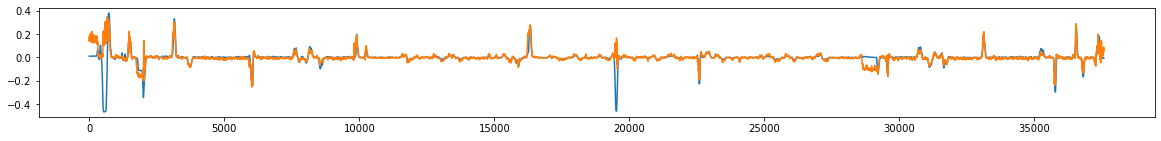

In [5]:
%%time

rw_evaluator = RwEvaluator(m, wandb=None, save_rollouts=True, run_ids=runs, do_sim=False, bptt=32) #TODO UNDO note bptt
rw_evaluator.evaluate()

In [6]:
%%time

# Make vids for all runs
run_ids = runs 
for rid in run_ids:
    make_enriched_vid(rid, model_stem, model_stem_b="7.9_e41") # "4.28_e107"

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
run_636_7.9_e81_VS_7.9_e41 done!
CPU times: user 6min 51s, sys: 29.1 s, total: 7min 20s
Wall time: 7min 21s


In [5]:
run_id = "run_555b"
rollout = load_object(f"{BESPOKE_ROOT}/tmp/{run_id}_{model_stem}_rollout.pkl")

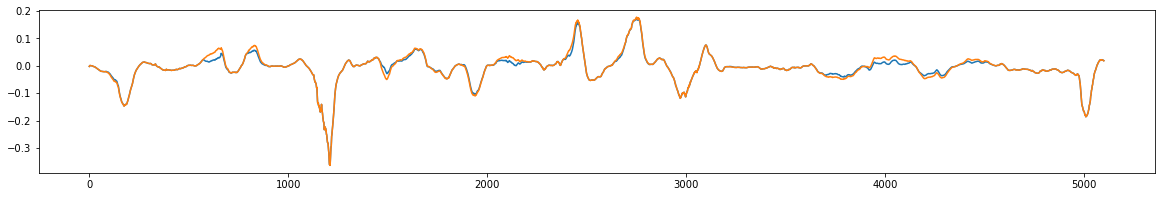

In [6]:
plt.figure(figsize=(20,3))
plt.plot(rollout.additional_results[:, "tire_angle_p"])
plt.plot(rollout.additional_results[:, "tire_angle_p_no_rc"])

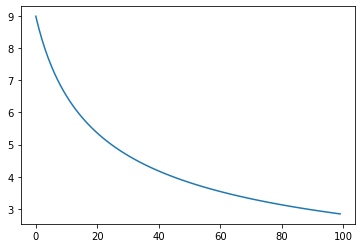

In [25]:
plt.plot([tire_angles_to_max_speeds(a) for a in np.linspace(.05, .5, num=100)])

In [30]:
mps_to_mph(tire_angles_to_max_speeds(.4))

7.114247304069718

In [3]:
import numpy
np.log(.1), np.log(.7), np.log(.9)

(-2.3025850929940455, -0.35667494393873245, -0.10536051565782628)

-0.00037538731394458135


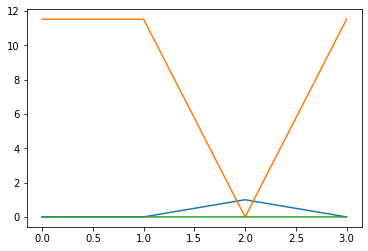

In [49]:
p = np.array([.00001,.00001,.99997,.00001])
lp = np.log(p)
e = p*lp
print(sum(e))

plt.plot(p)
plt.plot(-lp)
plt.plot(p*-lp)

-1.0011301846621206


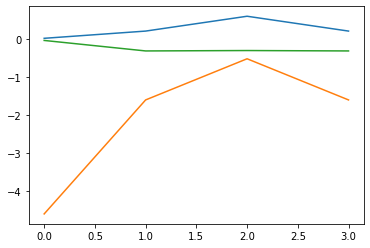

In [34]:
p = np.array([.01,.2,.59,.2])
lp = np.log(p)
e = p*lp
print(sum(e))

plt.plot(p)
plt.plot(lp)
plt.plot(p*lp)

-1.3862943611198906


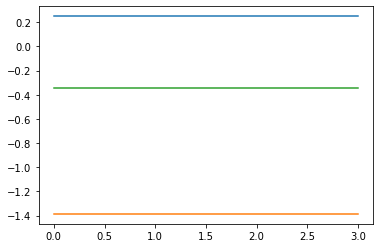

In [42]:
p = np.array([.25]*4)
lp = np.log(p)
e = p*lp
print(sum(e))

plt.plot(p)
plt.plot(lp)
plt.plot(p*lp)

In [45]:
np.log(4)

1.3862943611198906

In [50]:
np.array([.1]*8)

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [76]:
a = np.random.randn(10)
a.round(2)

array([-0.67, -0.5 ,  0.63,  0.22, -0.73, -0.97, -0.07,  0.85,  0.15,
       -0.48])

In [77]:
a.mean(), (a**2).mean()**.5

(-0.1569123483959632, 0.5991859621172766)

In [73]:
a = np.ones(10) * .7
a

array([0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7])

In [74]:
a.mean(), (a**2).mean()**.5

(0.7, 0.7)

In [55]:
(np.array([.1, )**2).mean()**.5

0.1

In [16]:
np.log(1)

0.0

In [13]:
10**-.1

0.7943282347242815

In [9]:
r = load_object(f"{BESPOKE_ROOT}/tmp/run_555b_3.10_e16_rollout.pkl")

In [10]:
wp_angles_p, wp_headings_p, wp_curvatures_p, wp_rolls_p, wp_zs_p = np.split(r.wps_p, 5, -1)

In [23]:
rm = RollsManager()
rolls = []
for i in range(len(wp_rolls_p)):
    rolls.append(rm.step(wp_rolls_p[i]))

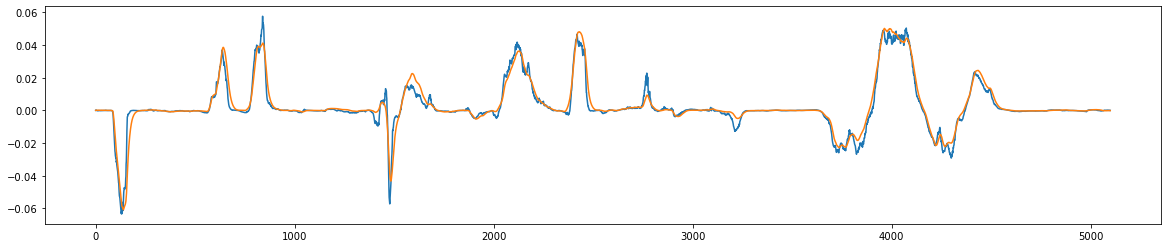

In [24]:
plt.figure(figsize=(20,4))
plt.plot(wp_rolls_p[:,0])
#plt.plot(moving_average(wp_rolls_p[3500:4500,:6].mean(-1), 20))
plt.plot(rolls[:])

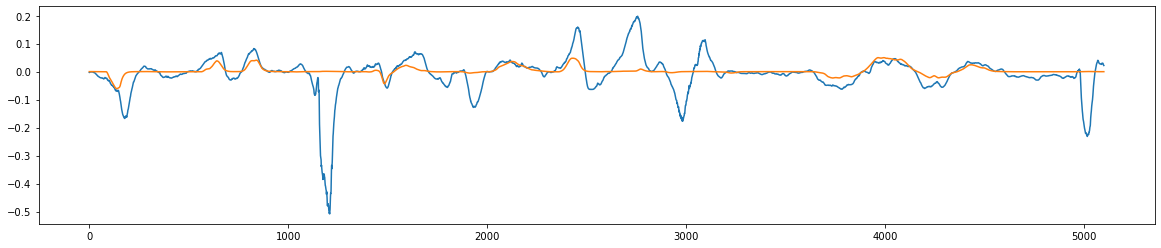

In [25]:
plt.figure(figsize=(20,4))
plt.plot(r.additional_results[:, "tire_angle_p"])
plt.plot(rolls[:])

In [4]:
run = load_object(f"{SSD_ROOT}/runs/run_555b.pkl")

In [23]:
"""# seeing if cam is too slow, ie if we ever have repeated imgs

diffs = []
for i in range(len(img)-1):
    diff = (img[i] - img[i+1]).mean()
    diffs.append(diff)
    
# whether or not image is same as prev img, ie cam is slow. We just don't want to see zeros
plt.figure(figsize=(20,2))
plt.plot(diffs)"""

"# seeing if cam is too slow, ie if we ever have repeated imgs\n\ndiffs = []\nfor i in range(len(img)-1):\n    diff = (img[i] - img[i+1]).mean()\n    diffs.append(diff)\n    \n# whether or not image is same as prev img, ie cam is slow. We just don't want to see zeros\nplt.figure(figsize=(20,2))\nplt.plot(diffs)"

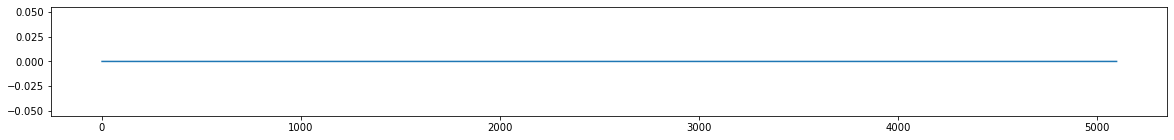

In [7]:
# img staleness
plt.figure(figsize=(20,2))
plt.plot(run.aux_chunk[0,:,'frame_to_model_duration'])

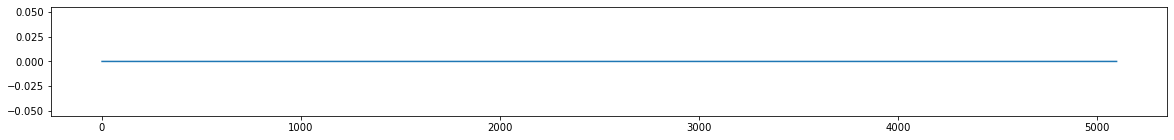

In [8]:
# loop duration
plt.figure(figsize=(20,2))
plt.plot(run.aux_chunk[0,:,'loop_duration'])

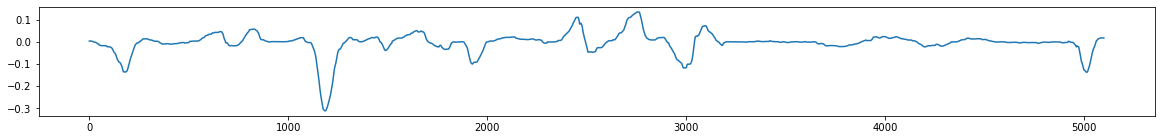

In [9]:
# tire angle
plt.figure(figsize=(20,2))
plt.plot(run.aux_chunk[0,:,'tire_angle'])

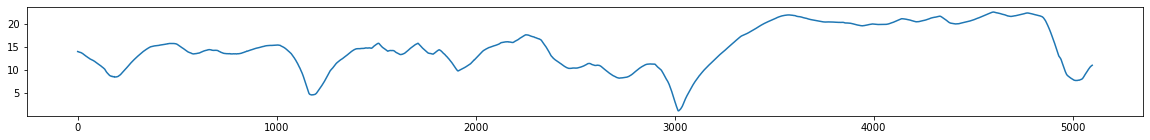

In [10]:
# speed
plt.figure(figsize=(20,2))
plt.plot(run.aux_chunk[0,:,'speed'])

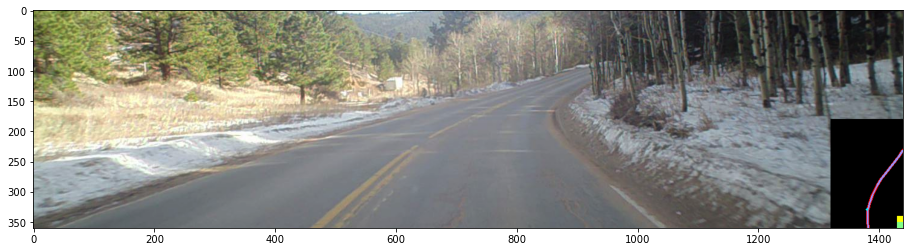

In [5]:
ix = 2100
plt.figure(figsize=(20,4))
plt.imshow(run.img_chunk[0, ix, :,:,:3])

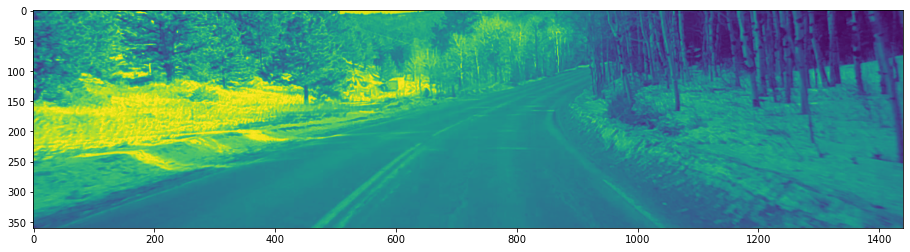

In [6]:
plt.figure(figsize=(20,4))
plt.imshow(run.img_chunk[0, ix, :,:,3:])

In [12]:
import plotly.graph_objects as go
import plotly.express as px

y = run.aux_chunk[0, :, "speed"]
fig = px.scatter(x=list(range(len(y))), y=y, width=1000, height=400)
#fig.update_xaxes(range=[0, 50])
#fig.update_yaxes(range=[0, 12])
fig.show()

In [28]:
"""import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(x=kph_to_mph(aux[:, 2]), y=np.sqrt(1/abs(steer_angle+.001)), width=600, height=600)
#fig.update_xaxes(range=[0, 50])
fig.update_yaxes(range=[0, 12])
fig.show()
"""
# The speed you can go is a linear fn of sqrt(1/curvature), steer_angle is a linear fn of curvature, given wheelbase

'import plotly.express as px\nimport plotly.graph_objects as go\n\nfig = px.scatter(x=kph_to_mph(aux[:, 2]), y=np.sqrt(1/abs(steer_angle+.001)), width=600, height=600)\n#fig.update_xaxes(range=[0, 50])\nfig.update_yaxes(range=[0, 12])\nfig.show()\n'

14686390.0

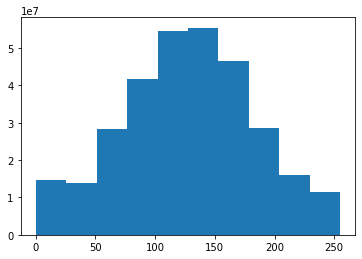

In [29]:
plt.hist(run.img_chunk[::20, :,:,:3].flatten())[0][0]

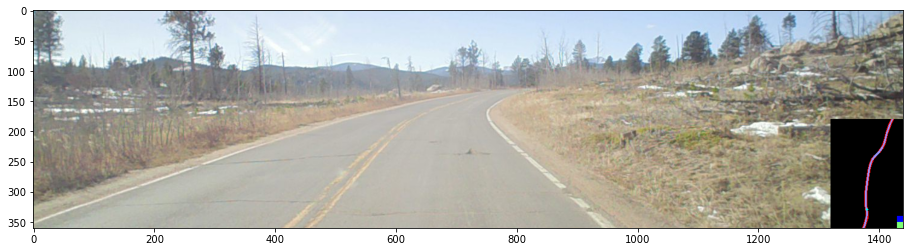

In [9]:
plt.figure(figsize=(20,4))
plt.imshow(run.img_chunk[0,1000, :,:,:3])